**Arshia Yousefinejad**

Rahnema college machine learning Bootcamp challenge code winter 2022

Update the code on 10 january 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category-encoders

In [ ]:
import os
import pprint
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv("./drive/MyDrive/Rahnema_college/100k_a.csv", names=['user_id', 'stream_id', 'streamer_name', 'start_time', 'stop_time'])
dataset = data.copy()


## Preprocessing on dataset

For train the model I needed "rating" column.for create "rating" column I extracted some features ( include time_spend, time_spend_count and time_Spend_mean )


*   **time_spend** = how long the user was in the chat
*   **time_spend_mean** = Average times the user spends in the streamer chat
*   **time_spend_count** = Number of times that user seen in the streamer chat


I used groupby operation for extract time_spend_count and time_spend_mean features.

And then for create "rating" column, I multiplied the columns of time_spend_mean and time_spend_count together.
*   **Rating** = time_spend_count * time_spend_mean

This process reduce the amount of row from 3051733 to 1505158



**Note :** "Rating" means user interest rate than streamer channel

In [ ]:
# create time spend column
dataset['time_spend'] = dataset['stop_time'] - dataset['start_time']

# drop stream_id becuase not useful !!! and also start time and stop time
dataset.drop(['stream_id', 'start_time', 'stop_time'],axis=1, inplace=True)

# copy streamers name to column 'streamer_name_copy'
dataset['streamer_name_copy'] = dataset['streamer_name']

In [ ]:
# encode streamer_name
encoder= ce.OrdinalEncoder(cols=['streamer_name'],return_df=True)
dataset = encoder.fit_transform(dataset)

# rename streamer_name to streamer_id and streamer_name_copy to streamer_name
dataset.rename(columns={'streamer_name': 'streamer_id'}, inplace=True)
dataset.rename(columns={'streamer_name_copy': 'streamer_name'}, inplace=True)

df = dataset.copy()
df.drop(['streamer_name'], axis=1, inplace=True)

In [ ]:
grouped = df.groupby(['user_id', 'streamer_id']).time_spend.agg(['count','mean'])
grouped.rename(columns={'count': 'time_spend_count', 'mean': 'time_spend_mean'}, inplace=True)
df_new = grouped.reset_index()

# create rating column
df_new['rating'] = df_new.time_spend_count * df_new.time_spend_mean

df_new.drop(['time_spend_count', 'time_spend_mean'], axis=1, inplace=True)
df = df_new.copy()

In [ ]:
print("dataset's row befor process : ", dataset.shape[0])
print("dataset's row after process : ", df.shape[0])

dataset's row befor process :  3051733
dataset's row after process :  1505158


The "rating" column was created :)

In [ ]:
df.head(5)

,user_id,streamer_id,rating
0,1,1,10.0
1,1,2,3.0
2,1,3,11.0
3,1,4,4.0
4,1,5,3.0


Preform preprocess on "rating" column

To solve the problem of "rating" column's data scatter, I used the percentile

By doing this, "rating" column's data includes numbers one, two, three, four and five

In [ ]:
percentiles_numbers = df['rating'].quantile([0.2, 0.4, 0.6 , 0.8]).tolist()

def update_rating_col(row):
  if row.rating <= percentiles_numbers[0]:
    row.rating = 1
  elif percentiles_numbers[0] < row.rating <= percentiles_numbers[1]:
    row.rating = 2
  elif percentiles_numbers[1] < row.rating <= percentiles_numbers[2]:
    row.rating = 3
  elif percentiles_numbers[2] < row.rating <= percentiles_numbers[3]:
    row.rating = 4
  else:
    row.rating = 5

  return row
df = df.apply(update_rating_col, axis='columns')

In [ ]:
df.head(5)

,user_id,streamer_id,rating
0,1.0,1.0,5.0
1,1.0,2.0,3.0
2,1.0,3.0,5.0
3,1.0,4.0,4.0
4,1.0,5.0,3.0


In [ ]:
# create columns "user" and "streamer" that Starting user_id numbers and stream_id numbers from zero ( becuase this numbers starting from one )
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
streamer_ids = df["streamer_id"].unique().tolist()
streamer2streamer_encoded = {x: i for i, x in enumerate(streamer_ids)}
streamer_encoded2streamer = {i: x for i, x in enumerate(streamer_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["streamer"] = df["streamer_id"].map(streamer2streamer_encoded)

num_users = len(user2user_encoded)
num_streamers = len(streamer_encoded2streamer)

df["rating"] = df["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Streamers: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_streamers, min_rating, max_rating
    )
)


Number of users: 100000, Number of Streamers: 162625, Min rating: 1.0, Max rating: 5.0


## Prepare training and validation data

In [ ]:
# shuffle df
df = df.sample(frac=1, random_state=42)

x = df[["user", "streamer"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data.
x_train, x_rem, y_train, y_rem = train_test_split(x, y, test_size=0.2, random_state=42)
# Assuming testing on 10% of the data and validation 10%
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42)

## Create the model

In [ ]:
'''The model computes a match score between user and movie embeddings via a dot product,
   and adds a per-movie and per-user bias.
    The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).'''

EMBEDDING_SIZE = 32
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_streamers, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_streamers = num_streamers
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.streamer_embedding = layers.Embedding(
            num_streamers,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.streamer_bias = layers.Embedding(num_streamers, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        streamer_vector = self.streamer_embedding(inputs[:, 1])
        streamer_bias = self.streamer_bias(inputs[:, 1])
        dot_user_streamer = tf.tensordot(user_vector, streamer_vector, 2)
        # Add all the components (including bias)
        x = dot_user_streamer + user_bias + streamer_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_streamers, EMBEDDING_SIZE)
# Use optimizer Adam, loss MSE, metrics RMSE
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.RootMeanSquaredError()
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train and save the model

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=3,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/3
18815/18815 [==============================] - 1440s 76ms/step - loss: 0.6400 - root_mean_squared_error: 0.5852 - val_loss: 0.6945 - val_root_mean_squared_error: 0.5952
Epoch 2/3
18815/18815 [==============================] - 1442s 77ms/step - loss: 0.6493 - root_mean_squared_error: 0.5865 - val_loss: 0.6648 - val_root_mean_squared_error: 0.5884
Epoch 3/3
18815/18815 [==============================] - 1444s 77ms/step - loss: 0.6323 - root_mean_squared_error: 0.5794 - val_loss: 0.6533 - val_root_mean_squared_error: 0.5841


## Plot training and validation loss


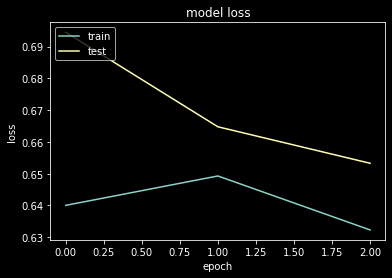

In [ ]:
plt.style.use('dark_background')

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Evaluate the model

In [ ]:
model.evaluate(x_test, y_test)

4704/4704 [==============================] - 84s 18ms/step - loss: 0.6378 - root_mean_squared_error: 0.5707


[0.6377769112586975, 0.5706755518913269]

In [ ]:
pred = model.predict(x_test[:10])
[print(pred[i], y_test[i]) for i in range(0, 10)]

[0.658729] 0.5
[0.0221929] 1.0
[0.28403875] 1.0
[0.9165152] 1.0
[0.01188853] 0.0
[0.7014334] 0.0
[0.9999972] 1.0
[0.04651526] 0.0
[0.16450796] 0.75
[0.00033048] 0.0


[None, None, None, None, None, None, None, None, None, None]